In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from statsmodels.formula.api import ols, logit, probit
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.formula.api import logit
import statsmodels.formula.api as smf
from datetime import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.stats.api as sms
from linearmodels.panel import PanelOLS
import statsmodels.stats.diagnostic as smsd
import statsmodels.api as sm     


In [10]:
# 1. Загрузка данных
file_path = '/Users/ishumeiko/Desktop/bank_data_FINAL.xlsx'  # путь к файлу
xls = pd.ExcelFile(file_path, engine='openpyxl') 

# Получаем названия листов
sheet_names = xls.sheet_names

# Создаем словарь с банковскими данными (все листы кроме последнего)
bank_data = {}
for sheet_name in sheet_names[:-1]:
    bank_data[sheet_name] = xls.parse(sheet_name)

# Загружаем макропоказатели (последний лист)
macro_data = xls.parse(sheet_names[-1])

# 2. Очистка данных
for bank in bank_data:
    bank_data[bank].dropna(inplace=True)

macro_data.dropna(inplace=True)

# Переименование 'Квартал' → 'Период' в макропоказателях для объединения
macro_data.rename(columns={"Квартал": "Период"}, inplace=True)


# 3.Объединяем все банки в одну таблицу
all_banks_data = pd.concat(bank_data.values(), ignore_index=True)

# Объединяем с макропоказателями
all_banks_data = pd.merge(all_banks_data, macro_data, on='Период', how='left')

# Проверка: выводим названия всех колонок
print("Столбцы объединённой таблицы:")
print(all_banks_data.columns)
for bank, data in bank_data.items():
    print(f"Описательная статистика для {bank}:")
    print(data.describe())
    print("\n")


Столбцы объединённой таблицы:
Index(['Период', 'Банк', 'ROE ', 'ROA ', 'Рыночная капитализация, млр. руб.',
       'LDR (Loan/deposit)', 'Активы банка, млрд.руб.', 'ln(активы)',
       'Размер банка', 'Норматив достаточности собственных средств банка H1.0',
       'Норматив достаточности базового капитала банка H1.1',
       'Норматив достаточности основного капитала банка H1.2',
       'Индикатор мгновенной ликвидности H2 ', 'Ключевая ставка (%)',
       'Средний курс USD/RUB', 'Средний курс EUR/RUB',
       'Spred between key rate and rusfar',
       'Средний спред по полю (офз: офз-пд, su26219r)',
       'Средний спред по полю (офз: офз-пд, su26219r26207 (офз-пд, su26207r)',
       'Средний спред по полю (26221 (офз-пд, su26221r)'],
      dtype='object')
Описательная статистика для СБЕРБАНК:
            ROE        ROA   Рыночная капитализация, млр. руб.  \
count  24.000000  24.000000                          24.000000   
mean    0.229083   0.029875                        5593.791667

In [ ]:
#print(sheet_names)


In [11]:
# 1. переименуем длинные заголовки в короткие
h_rename = {
    'Норматив достаточности собственных средств банка H1.0': 'H1_0',
    'Норматив достаточности базового капитала банка H1.1':  'H1_1',
    'Норматив достаточности основного капитала банка H1.2': 'H1_2',
}
all_banks_data.rename(columns=h_rename, inplace=True)

# очищаем строки и превращаем во float
def to_float(s):
    import numpy as np
    return (s.astype(str)
             .str.replace(r'\s',  '', regex=True)   # пробелы/NBSP
             .str.replace(',',    '.', regex=False) # , → .
             .str.replace('%',    '',  regex=False) # убираем %
             .str.replace('[–—]', '',  regex=True)  # тире
             .replace({'nan': np.nan, '': np.nan})
             .astype(float))

for col in ['H1_0', 'H1_1', 'H1_2']:
    all_banks_data[col] = to_float(all_banks_data[col])

# 3. проверяем числовые или нет
print(all_banks_data[['H1_0','H1_1','H1_2']].dtypes)


H1_0    float64
H1_1    float64
H1_2    float64
dtype: object


In [12]:
# --- 4.1  VIF-анализ на мультиколлинеарность -----------------------------
vif_features = [
    'LDR (Loan/deposit)',
    'ln(активы)',
    'H1_0',                                    # Норматив достаточности собственных средств
    'H1_1',                                    # Норматив достаточности базового капитала
    'H1_2',                                    # Норматив достаточности основного капитала
    'Индикатор мгновенной ликвидности H2 ',    # пробел в конце оставить!
    'Ключевая ставка (%)',
    'Средний курс USD/RUB',
    'Средний курс EUR/RUB',
    'Spred between key rate and rusfar',
    'Средний спред по полю (офз: офз-пд, su26219r)',
    'Средний спред по полю (офз: офз-пд, su26219r26207 (офз-пд, su26207r)',
    'Средний спред по полю (26221 (офз-пд, su26221r)',
]

# матрица признаков + константа
X = all_banks_data[vif_features].dropna().copy()
X = sm.add_constant(X)

# расчёт VIF
vif = pd.Series(
    [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
    index=X.columns,
    name='VIF'
)

print('\n=== VIF (full spec) ===')
print(vif.round(2).sort_values(ascending=False))
# -------------------------------------------------------------------------
# -------------------------------------------------------------------------



=== VIF (full spec) ===
const                                                                   242.34
Средний курс USD/RUB                                                     21.65
Средний курс EUR/RUB                                                     15.47
H1_0                                                                      6.45
H1_1                                                                      6.25
Средний спред по полю (офз: офз-пд, su26219r26207 (офз-пд, su26207r)      4.60
Средний спред по полю (офз: офз-пд, su26219r)                             3.90
Ключевая ставка (%)                                                       3.14
Средний спред по полю (26221 (офз-пд, su26221r)                           3.11
Spred between key rate and rusfar                                         2.44
H1_2                                                                      1.22
Индикатор мгновенной ликвидности H2                                       1.15
ln(активы)                 

print(all_banks_data.columns.tolist())
# ['Период', 'Банк', 'ROE ', 'ROA ', 'Рыночная капитализация, млр. руб.',
#  'LDR (Loan/deposit)', 'Активы банка, млрд.руб.', 'ln(активы)',
#  'Норматив достаточности собственных средств банка H1.0',
#  'Норматив достаточности базового капитала банка H1.1',
#  'Норматив достаточности основного капитала банка H1.2',
#  'Индикатор мгновенной ликвидности H2 ', ...]


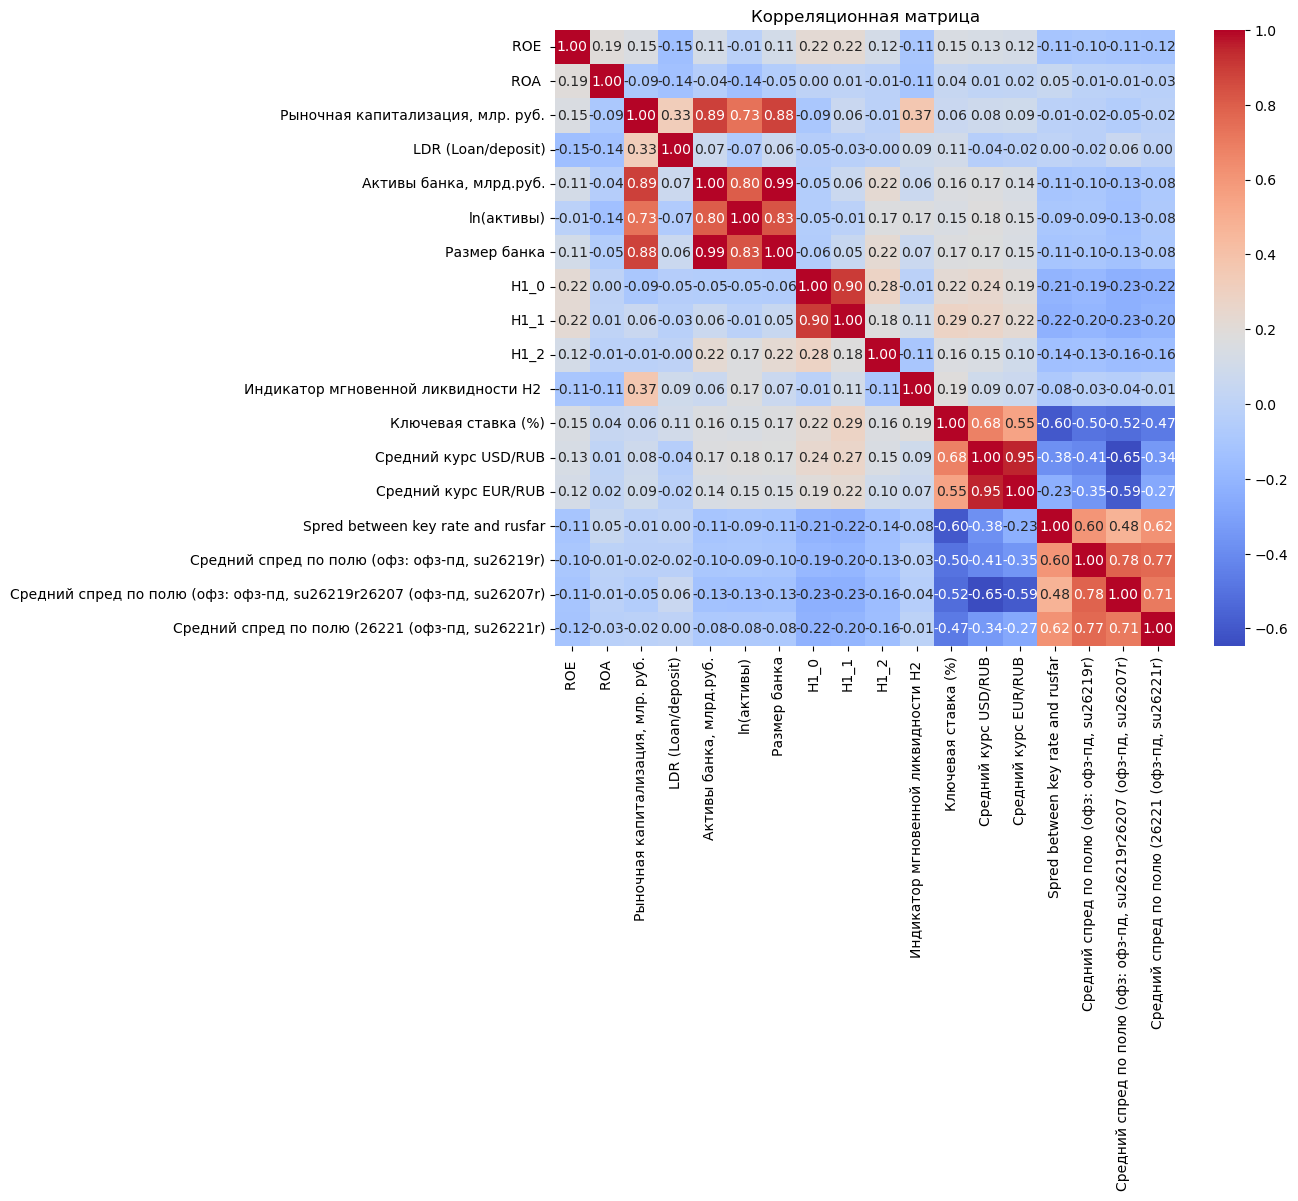

Index(['Период', 'Банк', 'ROE ', 'ROA ', 'Рыночная капитализация, млр. руб.',
       'LDR (Loan/deposit)', 'Активы банка, млрд.руб.', 'ln(активы)',
       'Размер банка', 'H1_0', 'H1_1', 'H1_2',
       'Индикатор мгновенной ликвидности H2 ', 'Ключевая ставка (%)',
       'Средний курс USD/RUB', 'Средний курс EUR/RUB',
       'Spred between key rate and rusfar',
       'Средний спред по полю (офз: офз-пд, su26219r)',
       'Средний спред по полю (офз: офз-пд, su26219r26207 (офз-пд, su26207r)',
       'Средний спред по полю (26221 (офз-пд, su26221r)'],
      dtype='object')


In [16]:
# 4. Корр анализ с визуализацией
# Фильтруем только числовые столбцы
numeric_data = all_banks_data.select_dtypes(include=[np.number])

# Вычисляем корреляционную матрицу
correlation_matrix = numeric_data.corr()

# Визуализируем корреляционную матрицу
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Корреляционная матрица")
plt.show()

print(all_banks_data.columns)



   


In [18]:

# 1) FULL OLS-модель для ROE со всеми переменными

# Подготовка
df = all_banks_data.copy()
df.rename(columns=lambda c: c.strip(), inplace=True)    # убираем хвостовые пробелы
df['Период'] = df['Период'].astype(str)                # фиксируем тип периода

def find_col(rx):
    """Возвращает первое имя столбца, подходящее под regex `rx`."""
    return next(c for c in df.columns if re.search(rx, c, flags=re.I))

# Базовые банковские показатели
ldr  = find_col(r'LDR')
h2   = find_col(r'ликвидн.*H2')
h12  = find_col(r'H1[_.,]2')           # H1.2
h10  = find_col(r'H1[_.,]0')           # H1.0
h11  = find_col(r'H1[_.,]1')           # H1.1

# Полный список предикторов (ровно как в датасете)
all_predictors = [
    ldr,
    "ln(активы)",
    h10,
    h11,
    h12,
    h2,
    "Ключевая ставка (%)",
    "Средний курс USD/RUB",
    "Средний курс EUR/RUB",
    "Spred between key rate and rusfar",
    "Средний спред по полю (офз: офз-пд, su26219r)",
    "Средний спред по полю (офз: офз-пд, su26219r26207 (офз-пд, su26207r)",
    "Средний спред по полю (26221 (офз-пд, su26221r)",
]

def make_formula(dep, predictors):
    rhs = " + ".join(f"Q('{c}')" for c in predictors) + " + C(Банк) + C(Период)"
    return f"{dep} ~ {rhs}"

# Полная модель для ROE
formula_roe_full = make_formula('ROE', all_predictors)
model_roe_full   = smf.ols(formula_roe_full, data=df).fit()

print("\n=== FULL MODEL (ROE) ===")
print(model_roe_full.summary())



=== FULL MODEL (ROE) ===
                            OLS Regression Results                            
Dep. Variable:                    ROE   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     11.92
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           1.49e-42
Time:                        19:54:50   Log-Likelihood:                 346.00
No. Observations:                 336   AIC:                            -606.0
Df Residuals:                     293   BIC:                            -441.9
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

In [63]:
#посмотрели на VIF - точно убираем: Средний курс USD/RUB, H1_0, H1_1
# Подготовка
df = all_banks_data.copy()
df.rename(columns=lambda c: c.strip(), inplace=True)    # убираем хвостовые пробелы
df['Период'] = df['Период'].astype(str)                # фиксируем тип периода

def find_col(rx):
    """Возвращает первое имя столбца, подходящее под regex `rx`."""
    return next(c for c in df.columns if re.search(rx, c, flags=re.I))

# Базовые банковские показатели
ldr  = find_col(r'LDR')
h2   = find_col(r'ликвидн.*H2')
h12  = find_col(r'H1[_.,]2')           # H1.2
h10  = find_col(r'H1[_.,]0')           # H1.0
h11  = find_col(r'H1[_.,]1')           # H1.1

# Полный список предикторов (ровно как в датасете)
all_predictors = [
    ldr,
    "ln(активы)",
    h12,
    h2,
    "Ключевая ставка (%)",
        "Средний спред по полю (офз: офз-пд, su26219r)",

    "Средний спред по полю (офз: офз-пд, su26219r26207 (офз-пд, su26207r)",
    "Средний спред по полю (26221 (офз-пд, su26221r)",
]

def make_formula(dep, predictors):
    rhs = " + ".join(f"Q('{c}')" for c in predictors) + " + C(Банк) + C(Период)"
    return f"{dep} ~ {rhs}"

# Полная модель для ROE
formula_roe_full = make_formula('ROE', all_predictors)
model_roe_full   = smf.ols(formula_roe_full, data=df).fit()

print("\n=== FULL MODEL (ROE) ===")
print(model_roe_full.summary())



=== FULL MODEL (ROE) ===
                            OLS Regression Results                            
Dep. Variable:                    ROE   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     12.57
Date:                Thu, 29 May 2025   Prob (F-statistic):           1.40e-43
Time:                        20:08:23   Log-Likelihood:                 345.78
No. Observations:                 336   AIC:                            -609.6
Df Residuals:                     295   BIC:                            -453.1
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

In [ ]:
#print(df[[h2, ldr]].corr().round(2))


In [65]:
# выберем спред который более значим

# Подготовка
df = all_banks_data.copy()
df.rename(columns=lambda c: c.strip(), inplace=True)    # убираем хвостовые пробелы
df['Период'] = df['Период'].astype(str)                # фиксируем тип периода

def find_col(rx):
    """Возвращает первое имя столбца, подходящее под regex `rx`."""
    return next(c for c in df.columns if re.search(rx, c, flags=re.I))

# Базовые банковские показатели
ldr  = find_col(r'LDR')
h2   = find_col(r'ликвидн.*H2')
h12  = find_col(r'H1[_.,]2')           # H1.2
h10  = find_col(r'H1[_.,]0')           # H1.0
h11  = find_col(r'H1[_.,]1')           # H1.1

# Полный список предикторов (ровно как в датасете)
all_predictors = [
    "ln(активы)",
    ldr,
    h12,
    h2,
    "Ключевая ставка (%)",
    "Средний курс EUR/RUB",
    "Spred between key rate and rusfar",
    "Средний спред по полю (офз: офз-пд, su26219r)",
]

def make_formula(dep, predictors):
    rhs = " + ".join(f"Q('{c}')" for c in predictors) + " + C(Банк) + C(Период)"
    return f"{dep} ~ {rhs}"

# Полная модель для ROE
formula_roe_full = make_formula('ROE', all_predictors)
model_roe_full   = smf.ols(formula_roe_full, data=df).fit()

print("\n=== FULL MODEL (ROE) ===")
print(model_roe_full.summary())



=== FULL MODEL (ROE) ===
                            OLS Regression Results                            
Dep. Variable:                    ROE   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     12.57
Date:                Thu, 29 May 2025   Prob (F-statistic):           1.40e-43
Time:                        20:08:31   Log-Likelihood:                 345.78
No. Observations:                 336   AIC:                            -609.6
Df Residuals:                     295   BIC:                            -453.1
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [67]:
#убираем ldr
# Подготовка
df = all_banks_data.copy()
df.rename(columns=lambda c: c.strip(), inplace=True)    # убираем хвостовые пробелы
df['Период'] = df['Период'].astype(str)                # фиксируем тип периода

def find_col(rx):
    """Возвращает первое имя столбца, подходящее под regex `rx`."""
    return next(c for c in df.columns if re.search(rx, c, flags=re.I))

# Базовые банковские показатели
ldr  = find_col(r'LDR')
h2   = find_col(r'ликвидн.*H2')
h12  = find_col(r'H1[_.,]2')           # H1.2
h10  = find_col(r'H1[_.,]0')           # H1.0
h11  = find_col(r'H1[_.,]1')           # H1.1

# Полный список предикторов (ровно как в датасете)
all_predictors = [
    "ln(активы)",
    h2,
    h12,
    "Ключевая ставка (%)",
    "Средний курс EUR/RUB",
    "Spred between key rate and rusfar",
    "Средний спред по полю (офз: офз-пд, su26219r)",
]

def make_formula(dep, predictors):
    rhs = " + ".join(f"Q('{c}')" for c in predictors) + " + C(Банк) + C(Период)"
    return f"{dep} ~ {rhs}"

# Полная модель для ROE
formula_roe_full = make_formula('ROE', all_predictors)
model_roe_full   = smf.ols(formula_roe_full, data=df).fit()

print("\n=== FULL MODEL (ROE) ===")
print(model_roe_full.summary())


=== FULL MODEL (ROE) ===
                            OLS Regression Results                            
Dep. Variable:                    ROE   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     12.89
Date:                Thu, 29 May 2025   Prob (F-statistic):           5.31e-44
Time:                        20:08:33   Log-Likelihood:                 345.40
No. Observations:                 336   AIC:                            -610.8
Df Residuals:                     296   BIC:                            -458.1
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [69]:
#убираем h2


# Подготовка
df = all_banks_data.copy()
df.rename(columns=lambda c: c.strip(), inplace=True)    # убираем хвостовые пробелы
df['Период'] = df['Период'].astype(str)                # фиксируем тип периода

def find_col(rx):
    """Возвращает первое имя столбца, подходящее под regex `rx`."""
    return next(c for c in df.columns if re.search(rx, c, flags=re.I))

# Базовые банковские показатели
ldr  = find_col(r'LDR')
h2   = find_col(r'ликвидн.*H2')
h12  = find_col(r'H1[_.,]2')           # H1.2
h10  = find_col(r'H1[_.,]0')           # H1.0
h11  = find_col(r'H1[_.,]1')           # H1.1

# Полный список предикторов (ровно как в датасете)
all_predictors = [
    "ln(активы)",
    ldr,
    h12,
    "Ключевая ставка (%)",
    "Средний курс EUR/RUB",
    "Spred between key rate and rusfar",
    "Средний спред по полю (офз: офз-пд, su26219r)",
]

def make_formula(dep, predictors):
    rhs = " + ".join(f"Q('{c}')" for c in predictors) + " + C(Банк) + C(Период)"
    return f"{dep} ~ {rhs}"

# Полная модель для ROE
formula_roe_full = make_formula('ROE', all_predictors)
model_roe_full   = smf.ols(formula_roe_full, data=df).fit()

print("\n=== FULL MODEL (ROE) ===")
print(model_roe_full.summary())



=== FULL MODEL (ROE) ===
                            OLS Regression Results                            
Dep. Variable:                    ROE   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     12.92
Date:                Thu, 29 May 2025   Prob (F-statistic):           4.41e-44
Time:                        20:08:37   Log-Likelihood:                 345.62
No. Observations:                 336   AIC:                            -611.2
Df Residuals:                     296   BIC:                            -458.6
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [71]:
# в итоге убираем оба: h2 and ldr

# Подготовка
df = all_banks_data.copy()
df.rename(columns=lambda c: c.strip(), inplace=True)    # убираем хвостовые пробелы
df['Период'] = df['Период'].astype(str)                # фиксируем тип периода

def find_col(rx):
    """Возвращает первое имя столбца, подходящее под regex `rx`."""
    return next(c for c in df.columns if re.search(rx, c, flags=re.I))

# Базовые банковские показатели
ldr  = find_col(r'LDR')
h2   = find_col(r'ликвидн.*H2')
h12  = find_col(r'H1[_.,]2')           # H1.2
h10  = find_col(r'H1[_.,]0')           # H1.0
h11  = find_col(r'H1[_.,]1')           # H1.1

# Полный список предикторов (ровно как в датасете)
all_predictors = [
    "ln(активы)",
    h12,
    "Ключевая ставка (%)",
    "Средний курс EUR/RUB",
    "Spred between key rate and rusfar",
    "Средний спред по полю (офз: офз-пд, su26219r)",
]

def make_formula(dep, predictors):
    rhs = " + ".join(f"Q('{c}')" for c in predictors) + " + C(Банк) + C(Период)"
    return f"{dep} ~ {rhs}"

# Полная модель для ROE
formula_roe_full = make_formula('ROE', all_predictors)
model_roe_full   = smf.ols(formula_roe_full, data=df).fit()

print("\n=== FULL MODEL (ROE) ===")
print(model_roe_full.summary())



=== FULL MODEL (ROE) ===
                            OLS Regression Results                            
Dep. Variable:                    ROE   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     13.25
Date:                Thu, 29 May 2025   Prob (F-statistic):           1.70e-44
Time:                        20:08:44   Log-Likelihood:                 345.20
No. Observations:                 336   AIC:                            -612.4
Df Residuals:                     297   BIC:                            -463.5
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [11]:
#убираем ключевую ставку - получаем финальную модель ROE  (но с гетероскдастичностью)


# Подготовка
df = all_banks_data.copy()
df.rename(columns=lambda c: c.strip(), inplace=True)    # убираем хвостовые пробелы
df['Период'] = df['Период'].astype(str)                # фиксируем тип периода

def find_col(rx):
    """Возвращает первое имя столбца, подходящее под regex `rx`."""
    return next(c for c in df.columns if re.search(rx, c, flags=re.I))

# Базовые банковские показатели
ldr  = find_col(r'LDR')
h2   = find_col(r'ликвидн.*H2')
h12  = find_col(r'H1[_.,]2')           # H1.2
h10  = find_col(r'H1[_.,]0')           # H1.0
h11  = find_col(r'H1[_.,]1')           # H1.1

# Полный список предикторов (ровно как в датасете)
all_predictors = [
    "ln(активы)",
    h12,
    "Средний курс EUR/RUB",
    "Spred between key rate and rusfar",
    "Средний спред по полю (офз: офз-пд, su26219r)",
]

def make_formula(dep, predictors):
    rhs = " + ".join(f"Q('{c}')" for c in predictors) + " + C(Банк) + C(Период)"
    return f"{dep} ~ {rhs}"

# Полная модель для ROE
formula_roe_full = make_formula('ROE', all_predictors)
model_roe_full   = smf.ols(formula_roe_full, data=df).fit()

print("\n=== FULL MODEL (ROE) ===")
print(model_roe_full.summary())



=== FULL MODEL (ROE) ===
                            OLS Regression Results                            
Dep. Variable:                    ROE   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     13.25
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           1.70e-44
Time:                        23:30:02   Log-Likelihood:                 345.20
No. Observations:                 336   AIC:                            -612.4
Df Residuals:                     297   BIC:                            -463.5
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [105]:
# ── Диагностика для модели `model_roe_full` ──────────────────────────
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox

# 1. Breusch–Pagan  (проверка гетероскедастичности)
bp_stat, bp_p, _, _ = sms.het_breuschpagan(
    model_roe_full.resid,              # остатки вашей OLS-модели
    model_roe_full.model.exog          # матрица регрессоров X
)
print(f"Breusch–Pagan  p-value = {bp_p:.3g}")

# 2. Durbin–Watson  (индикатор AR(1) зависимости ошибок)
dw = durbin_watson(model_roe_full.resid)
print(f"Durbin–Watson statistic = {dw:.2f}  (идеал ≈ 2)")

# 3. Ljung–Box Q-тест до 4-го лага  (общая серийная корреляция)
lb = acorr_ljungbox(model_roe_full.resid, lags=[4], return_df=True)
print(f"Ljung–Box Q(4)  p-value = {lb['lb_pvalue'].iloc[0]:.3g}")


Breusch–Pagan  p-value = 0.0181
Durbin–Watson statistic = 1.42  (идеал ≈ 2)
Ljung–Box Q(4)  p-value = 2.63e-11


In [13]:
# почти final MODEL WITH HAC 
mdl_hac = (
    smf.ols(formula_roe_full, data=df)
       .fit()
       .get_robustcov_results(cov_type="HAC", maxlags=4)
)

print("\n=== ROE  |  HAC-robust SE (4 lags) ===")
print(mdl_hac.summary())



=== ROE  |  HAC-robust SE (4 lags) ===
                            OLS Regression Results                            
Dep. Variable:                    ROE   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     53.61
Date:                Mon, 02 Jun 2025   Prob (F-statistic):          5.68e-112
Time:                        23:30:06   Log-Likelihood:                 345.20
No. Observations:                 336   AIC:                            -612.4
Df Residuals:                     297   BIC:                            -463.5
Df Model:                          38                                         
Covariance Type:                  HAC                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 41, but rank is 39
  warnings.warn('covariance of constraints does not have full '


In [ ]:
'/Users/ishumeiko/Desktop/bank_data_FINAL.xlsx'

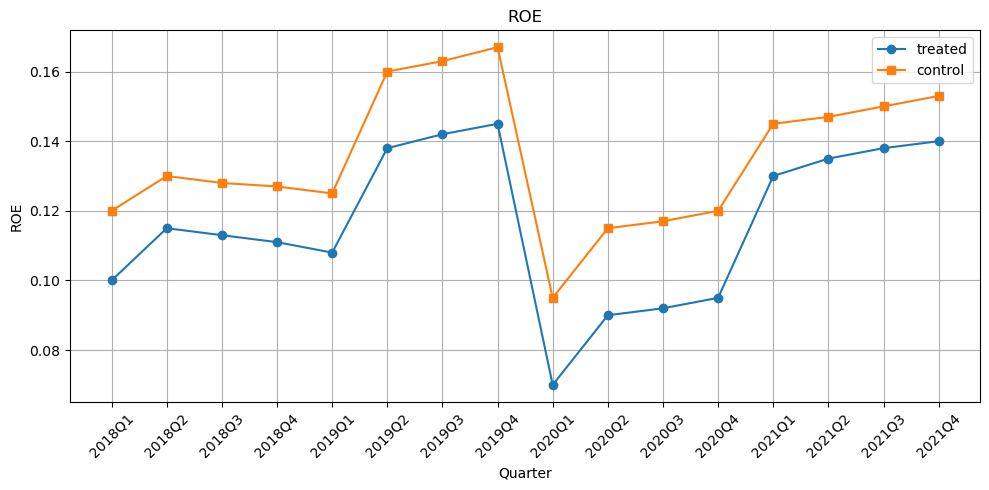

In [29]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Данные вручную по изображению (приблизительно)
quarters = [
    "2018Q1", "2018Q2", "2018Q3", "2018Q4",
    "2019Q1", "2019Q2", "2019Q3", "2019Q4",
    "2020Q1", "2020Q2", "2020Q3", "2020Q4",
    "2021Q1", "2021Q2", "2021Q3", "2021Q4"
]

treated = [
    0.10, 0.115, 0.113, 0.111,
    0.108, 0.138, 0.142, 0.145,
    0.07, 0.09, 0.092, 0.095,
    0.13, 0.135, 0.138, 0.14
]

control = [
    0.12, 0.13, 0.128, 0.127,
    0.125, 0.16, 0.163, 0.167,
    0.095, 0.115, 0.117, 0.12,
    0.145, 0.147, 0.15, 0.153
]

# Построение графика
plt.figure(figsize=(10, 5))
plt.plot(quarters, treated, marker='o', label='treated')
plt.plot(quarters, control, marker='s', label='control')
plt.xlabel('Quarter')
plt.ylabel('ROE')
plt.title('ROE')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [115]:

# 1.  final model ROE with hac(после того как убрали ln assets and spred) - ее используем в работе
mdl_hac = (
    smf.ols(formula_roe_full, data=df)
       .fit()
       .get_robustcov_results(cov_type="HAC", maxlags=4)
)

print("\n=== ROE  |  HAC-robust SE (4 lags) ===")
print(mdl_hac.summary())



=== ROE  |  HAC-robust SE (4 lags) ===
                            OLS Regression Results                            
Dep. Variable:                    ROE   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     53.73
Date:                Fri, 30 May 2025   Prob (F-statistic):          2.45e-111
Time:                        16:03:54   Log-Likelihood:                 341.79
No. Observations:                 336   AIC:                            -607.6
Df Residuals:                     298   BIC:                            -462.5
Df Model:                          37                                         
Covariance Type:                  HAC                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 39, but rank is 38
  warnings.warn('covariance of constraints does not have full '


In [119]:
# создаём лаг H1_2 как внешний инструмент
df['_H1_2_lag'] = df.groupby('Банк')[h12].shift(1)

# первая стадия: H1_2 регрессируется на инструмент + остальные X
iv_first = smf.ols(
    f"Q('{h12}') ~ _H1_2_lag + Q('ln(активы)') + "
    "Q('Средний курс USD/RUB') + "
    "Q('Spred between key rate and rusfar') + "
    "Q('Средний спред по полю (офз: офз-пд, su26219r)')",
    data=df
).fit()

# остатки первой стадии
df['_vhat'] = iv_first.resid

# вторая стадия: добавляем _vhat в исходную модель
hausman = smf.ols(formula_roe_full + " + _vhat", data=df).fit()

p_endog = hausman.pvalues['_vhat']
print(f"Durbin–Wu–Hausman  p-value = {p_endog:.3f}")
# p > 0.10 → эндогенности H1_2 не обнаружено


Durbin–Wu–Hausman  p-value = 0.275


In [27]:
# FULL OLS-модель для ROA со всеми теми же переменными

# 0. заново копируем датасет и правим заголовки
df = all_banks_data.copy()
df.rename(columns=str.strip, inplace=True)      # убираем хвостовые пробелы
df["Период"] = df["Период"].astype(str)

# 1. вспомогательная функция поиска колонок по regex
def find_col(rx):
    return next(c for c in df.columns if re.search(rx, c, flags=re.I))

# 2. точные имена банковских индикаторов
ldr  = find_col(r"LDR")
h2   = find_col(r"ликвидн.*H2")          # «Индикатор мгновенной ликвидности H2 …»
h10  = find_col(r"H1[_.,]0")
h11  = find_col(r"H1[_.,]1")
h12  = find_col(r"H1[_.,]2")

# 3. список предикторов (точно как в датасете)
all_predictors = [
    ldr, "ln(активы)",
    h10, h11, h12, h2,
    "Ключевая ставка (%)",
    "Средний курс USD/RUB",
    "Средний курс EUR/RUB",
    "Spred between key rate and rusfar",
    "Средний спред по полю (офз: офз-пд, su26219r)",
    "Средний спред по полю (офз: офз-пд, su26219r26207 (офз-пд, su26207r)",
    "Средний спред по полю (26221 (офз-пд, su26221r)",
]

# 4. формула и оценка модели ROA
def make_formula(dep, predictors):
    rhs = " + ".join(f"Q('{c}')" for c in predictors) + " + C(Банк) + C(Период)"
    return f"{dep} ~ {rhs}"

formula_roa_full = make_formula("ROA", all_predictors)
model_roa_full   = smf.ols(formula_roa_full, data=df).fit()

print("\n=== FULL MODEL (ROA) — обычный OLS ===")
print(model_roa_full.summary())



=== FULL MODEL (ROA) — обычный OLS ===
                            OLS Regression Results                            
Dep. Variable:                    ROA   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     8.013
Date:                Wed, 21 May 2025   Prob (F-statistic):           3.02e-29
Time:                        20:41:02   Log-Likelihood:                 739.70
No. Observations:                 336   AIC:                            -1393.
Df Residuals:                     293   BIC:                            -1229.
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [41]:
# тесты и регрессия и финальная модель ROA

# 1. Диагностика ошибок для ROA (OLS-модель без робастных SE)
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox

# 1.1 Breusch–Pagan  → гетероскедастичность
bp_stat, bp_p, _, _ = sms.het_breuschpagan(
    model_roa_full.resid,
    model_roa_full.model.exog
)
print(f"Breusch–Pagan p-value = {bp_p:.3g}")

# 1.2 Durbin–Watson  → AR(1) индикатор
dw = durbin_watson(model_roa_full.resid)
print(f"Durbin–Watson statistic = {dw:.2f}  (идеал ≈ 2)")

# 1.3 Ljung–Box Q(4)  → сериал-корреляция до 4 квартальных лагов
lb_p = acorr_ljungbox(model_roa_full.resid, lags=[4],
                      return_df=True)['lb_pvalue'].iloc[0]
print(f"Ljung–Box Q(4) p-value = {lb_p:.3g}")

# 2. HAC-робастные стандартные ошибки (Newey-West, 4 лага)

model_roa_hac = (
    smf.ols(formula_roa_full, data=df)
       .fit()
       .get_robustcov_results(cov_type='HAC', maxlags=4)
)

print("\n=== ROA  |  HAC-robust SE (4 квартальных лага) ===")
print(model_roa_hac.summary())


Breusch–Pagan p-value = 7.2e-20
Durbin–Watson statistic = 1.06  (идеал ≈ 2)
Ljung–Box Q(4) p-value = 7.24e-21

=== ROA  |  HAC-robust SE (4 квартальных лага) ===
                            OLS Regression Results                            
Dep. Variable:                    ROA   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     29.15
Date:                Wed, 21 May 2025   Prob (F-statistic):           3.67e-79
Time:                        20:44:10   Log-Likelihood:                 738.12
No. Observations:                 336   AIC:                            -1400.
Df Residuals:                     298   BIC:                            -1255.
Df Model:                          37                                         
Covariance Type:                  HAC                                         
                                coef    std err 

In [43]:
# Создаём лаг H1_2 как внешний инструмент
df['_H1_2_lag'] = df.groupby('Банк')[h12].shift(1)

# Первая стадия: H1_2 регрессируется на инструмент + остальные X
iv_first = smf.ols(
    f"Q('{h12}') ~ _H1_2_lag + Q('ln(активы)') + "
    "Q('Средний курс USD/RUB') + "
    "Q('Spred between key rate and rusfar') + "
    "Q('Средний спред по полю (офз: офз-пд, su26219r)')",
    data=df
).fit()

# Остатки первой стадии
df['_vhat'] = iv_first.resid

# Вторая стадия: добавляем _vhat в исходную модель ROA
formula_roa_full_with_vhat = make_formula('ROA', all_predictors) + " + _vhat"
hausman_roa = smf.ols(formula_roa_full_with_vhat, data=df).fit()

p_endog_roa = hausman_roa.pvalues['_vhat']
print(f"Durbin–Wu–Hausman test p-value for ROA = {p_endog_roa:.3f}")
# p > 0.10 → эндогенности H1_2 в модели ROA не обнаружено


Durbin–Wu–Hausman test p-value for ROA = 0.596


DID

In [20]:
# First DID with all variables
df = all_banks_data.copy()
df.rename(columns=lambda c: c.strip(), inplace=True)
df['Период'] = df['Период'].astype(str)          # "YYYY-QQ"
df['date']   = pd.to_datetime(df['Период'] + '-01')

# 1. The dates when banks were actually subjected to strict sanctions (inclusion on the SDN list)
sanction_dates = {
    'СБЕРБАНК':      '2022-03-06',
    'ВТБ':           '2022-02-24',
    'МКБ':           '2022-03-15',
    'АЛЬФА-БАНК':    '2022-03-06',
    'УРАЛСИБ':       '2022-03-15',
    'РОСБАНК':       '2022-05-15',
    'СОВКОМБАНК':    '2022-02-24',
}

# 2. indicators : Sanctioned, Post, DID
df['Sanctioned'] = df['Банк'].apply(lambda b: 1 if b in sanction_dates else 0)

def is_post(row):
    if row['Sanctioned'] == 0:
        return 0
    s_date = pd.to_datetime(sanction_dates[row['Банк']])
    return 1 if row['date'] >= s_date else 0
    
df['Post'] = df.apply(is_post, axis=1)
df['DID']  = df['Sanctioned'] * df['Post']

# 3. Function: create two models 
def run_did_models(frame: pd.DataFrame):
    base_ctrls  = ["Q('LDR (Loan/deposit)')",
                   "Q('ln(активы)')",
                   "Q('H1_2')",
                   "Q('Индикатор мгновенной ликвидности H2')"]
    
    macro_ctrls = base_ctrls + [
                   "Q('Ключевая ставка (%)')",
                   "Q('Spred between key rate and rusfar')",
                 ]
    
    def formula(dep, ctrls):
        rhs = " + ".join(ctrls + ['Sanctioned', 'Post', 'DID', 'C(Банк)', 'C(Период)'])
        return f"{dep} ~ {rhs}"
    
    did_base  = smf.ols(formula('ROE', base_ctrls),  data=frame).fit(cov_type='HC3')
    did_macro = smf.ols(formula('ROE', macro_ctrls), data=frame).fit(cov_type='HC3')
    return {'DiD_base': did_base, 'DiD_macro': did_macro}

did = run_did_models(df)

for name, mdl in did.items():
    print(f"\n=== {name} ===")
    print(mdl.summary())



=== DiD_base ===
                            OLS Regression Results                            
Dep. Variable:                    ROE   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     17.52
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           1.91e-57
Time:                        19:58:48   Log-Likelihood:                 353.45
No. Observations:                 336   AIC:                            -622.9
Df Residuals:                     294   BIC:                            -462.6
Df Model:                          41                                         
Covariance Type:                  HC3                                         
                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 43, but rank is 41
  warnings.warn('covariance of constraints does not have full '
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 45, but rank is 42
  warnings.warn('covariance of constraints does not have full '


In [53]:

# Предположим, что у вас уже есть датафрейм all_banks_data.
# Сначала скопируем его и создадим столбцы quarter, date, Sanctioned и т.д.

df = all_banks_data.copy()
df.rename(columns=lambda c: c.strip(), inplace=True)

# Убедимся, что 'Период' выглядит как "YYYY-Qx"
df['Период'] = df['Период'].astype(str)

# Преобразуем 'Период' в datetime (первая дата квартала) и в PeriodIndex
df['date']    = pd.to_datetime(df['Период'] + '-01')          # преобразование "2022-Q1" → "2022-01-01"
df['quarter'] = pd.PeriodIndex(df['Период'], freq='Q')         # превратить "2022-Q1" в Period('2022Q1')

# Признак «санкционный» (Sanctioned = 1, если банк хотя бы раз в SDN; иначе 0)
sanction_dates = {
    'СБЕРБАНК':   '2022-03-06',
    'ВТБ':        '2022-02-24',
    'МКБ':        '2022-03-15',
    'АЛЬФА-БАНК': '2022-03-06',
    'УРАЛСИБ':    '2022-03-15',
    'РОСБАНК':    '2022-05-15',
    'СОВКОМБАНК': '2022-02-24',
}
df['Sanctioned'] = df['Банк'].isin(sanction_dates).astype(int)

# Для удобства заменим 0/1 на текстовые метки «Control» и «Treated»
df['Group'] = df['Sanctioned'].map({0: 'Control', 1: 'Treated'})


In [77]:
# First DID with all variables
# Data preparation for DID analysis of ROE


df = all_banks_data.copy()
df.rename(columns=lambda c: c.strip(), inplace=True)
df['Период'] = df['Период'].astype(str)          # 'YYYY-QQ'
df['date']   = pd.to_datetime(df['Период'] + '-01')

#  SDN banks
sanction_dates = {
    'СБЕРБАНК':   '2022-03-06',
    'ВТБ':        '2022-02-24',
    'МКБ':        '2022-03-15',
    'АЛЬФА-БАНК': '2022-03-06',
    'УРАЛСИБ':    '2022-03-15',
    'РОСБАНК':    '2022-05-15',
    'СОВКОМБАНК': '2022-02-24',
}

df['Sanctioned'] = df['Банк'].isin(sanction_dates).astype(int)
df['Post']       = (df['date'] >= pd.Timestamp('2022-01-01')).astype(int)
df['DID']        = df['Sanctioned'] * df['Post']

assert df[['Sanctioned', 'Post', 'DID']].drop_duplicates().shape[0] == 4

controls = [
    "Q('LDR (Loan/deposit)')",
    "Q('ln(активы)')",
    "Q('H1_2')",
    "Q('Индикатор мгновенной ликвидности H2')",
    "Q('Ключевая ставка (%)')",
    "Q('Spred between key rate and rusfar')",
]

formula1 = "ROE ~ " + " + ".join(
    controls + ['Sanctioned', 'Post', 'DID', 'C(Банк)', 'C(Период)']
)

model1 = smf.ols(formula1, data=df).fit(cov_type='HC3')
print(model1.summary())


AssertionError: 

In [55]:
# final DID for ROE - cheching hypothesis 1/2 (Only with H1.2, Key rate, EUR/RUB)
# 1. Data preparation for DID analysis of ROE

df = all_banks_data.copy()
df.rename(columns=lambda c: c.strip(), inplace=True)
df['Период'] = df['Период'].astype(str)
df['date']   = pd.to_datetime(df['Период'] + '-01')

sanction_dates = {
    'СБЕРБАНК':   '2022-03-06',
    'ВТБ':        '2022-02-24',
    'МКБ':        '2022-03-15',
    'АЛЬФА-БАНК': '2022-03-06',
    'УРАЛСИБ':    '2022-03-15',
    'РОСБАНК':    '2022-05-15',
    'СОВКОМБАНК': '2022-02-24',
}

df['Sanctioned'] = df['Банк'].isin(sanction_dates).astype(int)
df['Post']       = (df['date'] >= pd.Timestamp('2022-01-01')).astype(int)
df['DID']        = df['Sanctioned'] * df['Post']

assert df[['Sanctioned', 'Post', 'DID']].drop_duplicates().shape[0] == 4

controls = [
    "Q('H1_2')",
    "Q('Ключевая ставка (%)')",
    "Q('Средний курс EUR/RUB')",
]

formula1 = "ROE ~ " + " + ".join(
    controls + ['Sanctioned', 'Post', 'DID', 'C(Банк)', 'C(Период)']
)

model1 = smf.ols(formula1, data=df).fit(cov_type='HC3')
print(model1.summary())


                            OLS Regression Results                            
Dep. Variable:                    ROE   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     51.86
Date:                Thu, 29 May 2025   Prob (F-statistic):          3.91e-110
Time:                        19:05:10   Log-Likelihood:                 349.05
No. Observations:                 336   AIC:                            -620.1
Df Residuals:                     297   BIC:                            -471.2
Df Model:                          38                                         
Covariance Type:                  HC3                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 42, but rank is 39
  warnings.warn('covariance of constraints does not have full '


In [57]:
#Checking hypothesis 3

df = all_banks_data.copy()
df.rename(columns=lambda c: c.strip(), inplace=True)
df['Период'] = df['Период'].astype(str)
df['date']   = pd.to_datetime(df['Период'] + '-01')

sanction_dates = {
    'СБЕРБАНК':   '2022-03-06',
    'ВТБ':        '2022-02-24',
    'МКБ':        '2022-03-15',
    'АЛЬФА-БАНК': '2022-03-06',
    'УРАЛСИБ':    '2022-03-15',
    'РОСБАНК':    '2022-05-15',
    'СОВКОМБАНК': '2022-02-24',
}

df['Sanctioned'] = df['Банк'].isin(sanction_dates).astype(int)          # 1 – банк попал в SDN
df['Post']       = (df['date'] >= pd.Timestamp('2022-01-01')).astype(int)  # 1 – 2022-Q1+
df['DID']        = df['Sanctioned'] * df['Post']                         # «санкции активны»


# 2. Large bank indicator (top 25% by total assets)
# -------------------------------------------------
q75            = df["ln(активы)"].quantile(0.75)
df['Big']      = (df["ln(активы)"] >= q75).astype(int)
df['DID_Big']  = df['DID'] * df['Big']      #  – крупный банк под санкциями после 2022-Q1


# 3.Hypothesis 3

controls = [
    "Q('H1_2')",
    "Q('Ключевая ставка (%)')"
]  # минимальный набор контролей, чтобы не усложнять

formula = (
    "ROE ~ "
    + " + ".join(controls + [
        'Sanctioned',         
        'Post',                # common shock in 2022-Q1
        'DID',                 # average sanction effect
        'Big',                 # large vs small banks (pre-sanctions)
        'DID_Big',             # test variable for Hypothesis 3
        'C(Банк)', 'C(Период)' # fixed effects
    ])
)

model_h3 = smf.ols(formula, data=df).fit(cov_type='HC3')
print(model_h3.summary())


                            OLS Regression Results                            
Dep. Variable:                    ROE   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     50.05
Date:                Thu, 29 May 2025   Prob (F-statistic):          1.39e-109
Time:                        19:05:17   Log-Likelihood:                 352.29
No. Observations:                 336   AIC:                            -622.6
Df Residuals:                     295   BIC:                            -466.1
Df Model:                          40                                         
Covariance Type:                  HC3                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 43, but rank is 41
  warnings.warn('covariance of constraints does not have full '


ROA

In [97]:
#ROA DID - fina;

# Data preparation 
df = all_banks_data.copy()
df.rename(columns=lambda c: c.strip(), inplace=True)
df['Период'] = df['Период'].astype(str)
df['date']   = pd.to_datetime(df['Период'] + '-01')

#The dates when banks were actually subjected to strict sanctions (inclusion on the SDN list)
sanction_dates = {
    'СБЕРБАНК':   '2022-03-06',
    'ВТБ':        '2022-02-24',
    'МКБ':        '2022-03-15',
    'АЛЬФА-БАНК': '2022-03-06',
    'УРАЛСИБ':    '2022-03-15',
    'РОСБАНК':    '2022-05-15',
    'СОВКОМБАНК': '2022-02-24',
}

df['Sanctioned'] = df['Банк'].isin(sanction_dates).astype(int)
df['Post']       = (df['date'] >= pd.Timestamp('2022-01-01')).astype(int)
df['DID']        = df['Sanctioned'] * df['Post']

# for H1/H2
controls = [
    "Q('H1_2')",
    "Q('Средний курс EUR/RUB')"
]

formula_roa = "ROA ~ " + " + ".join(
    controls + ['Sanctioned', 'Post', 'DID', 'C(Банк)', 'C(Период)']
)

roa_model12 = smf.ols(formula_roa, data=df).fit(cov_type='HC3')
print(roa_model12.summary())


                            OLS Regression Results                            
Dep. Variable:                    ROA   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     24.42
Date:                Mon, 26 May 2025   Prob (F-statistic):           2.64e-71
Time:                        20:09:41   Log-Likelihood:                 755.31
No. Observations:                 336   AIC:                            -1433.
Df Residuals:                     297   BIC:                            -1284.
Df Model:                          38                                         
Covariance Type:                  HC3                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 41, but rank is 39
  warnings.warn('covariance of constraints does not have full '


In [59]:
# Large bank indicator
q75           = df["ln(активы)"].quantile(0.75)
df['Big']     = (df["ln(активы)"] >= q75).astype(int)
df['DID_Big'] = df['DID'] * df['Big']

# Hypothesis 3 
controls_h3 = [
    "Q('H1_2')",
    "Q('Ключевая ставка (%)')"
]

formula_h3_roa = (
    "ROA ~ "
    + " + ".join(controls_h3 + [
        'Sanctioned',
        'Post',
        'DID',
        'Big',
        'DID_Big',              # Interaction term = test of Hypothesis 3
        'C(Банк)', 'C(Период)'
    ])
)

roa_model3 = smf.ols(formula_h3_roa, data=df).fit(cov_type='HC3')
print(roa_model3.summary())


                            OLS Regression Results                            
Dep. Variable:                    ROA   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     32.02
Date:                Thu, 29 May 2025   Prob (F-statistic):           6.37e-86
Time:                        19:12:10   Log-Likelihood:                 759.44
No. Observations:                 336   AIC:                            -1437.
Df Residuals:                     295   BIC:                            -1280.
Df Model:                          40                                         
Covariance Type:                  HC3                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 43, but rank is 41
  warnings.warn('covariance of constraints does not have full '
